In [26]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import function_library_assignment_2 as fnc

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['axes.axisbelow'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
random.seed(2) #seed to ensure that we can get the same random values again
wind_scenarios = random.sample(range(100), 50) #How many scenarios? Sampling without replacement - taking 100 samples will just get a list from 0 to 99
wind_scenarios.sort()
#wind_scenarios

In [28]:
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')[['C ($/MWh)', 'C+($/MWh)', 'C-($/MWh)']]
#line_data = fnc.read_data('line_data')
#branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=wind_scenarios) #The ED is only for a single hour - in this case, we choose hour 31

In [29]:
wind_data

,V4,V5,V8,V9,V11,V12,V21,V22,V23,V24,...,V87,V88,V91,V92,V94,V95,V96,V97,V99,Expected
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,57.28,77.72,54.77,88.26,61.53,110.61,71.05,77.94,115.27,57.29,...,69.48,70.44,69.20,72.38,49.65,133.94,145.62,104.54,67.36,87.84
2,54.45,36.67,82.92,118.74,74.31,172.25,46.52,91.44,95.29,71.93,...,23.53,90.80,172.27,76.48,54.13,65.01,119.32,93.82,76.89,84.95
3,82.77,22.09,159.62,119.69,131.08,189.10,74.89,50.63,71.08,69.60,...,90.58,103.93,83.01,73.25,152.92,76.48,109.01,62.66,159.71,95.18
4,36.10,59.74,104.59,126.92,93.21,155.17,90.25,54.32,60.76,64.77,...,115.05,92.78,93.59,52.61,119.34,59.24,180.08,45.01,105.68,94.18
5,30.09,52.93,40.39,50.97,60.83,66.38,71.84,52.53,37.53,43.59,...,76.27,22.96,115.22,29.54,20.28,37.58,36.29,58.14,20.20,53.94
6,3.27,21.48,34.24,41.17,23.60,42.66,65.36,85.24,83.09,10.33,...,1.33,5.31,17.47,45.18,61.70,100.68,26.37,41.55,57.98,54.71


In [30]:
wind_data.loc[wind_data.index == 1].index

Int64Index([1], dtype='int64', name='Wind Farm')

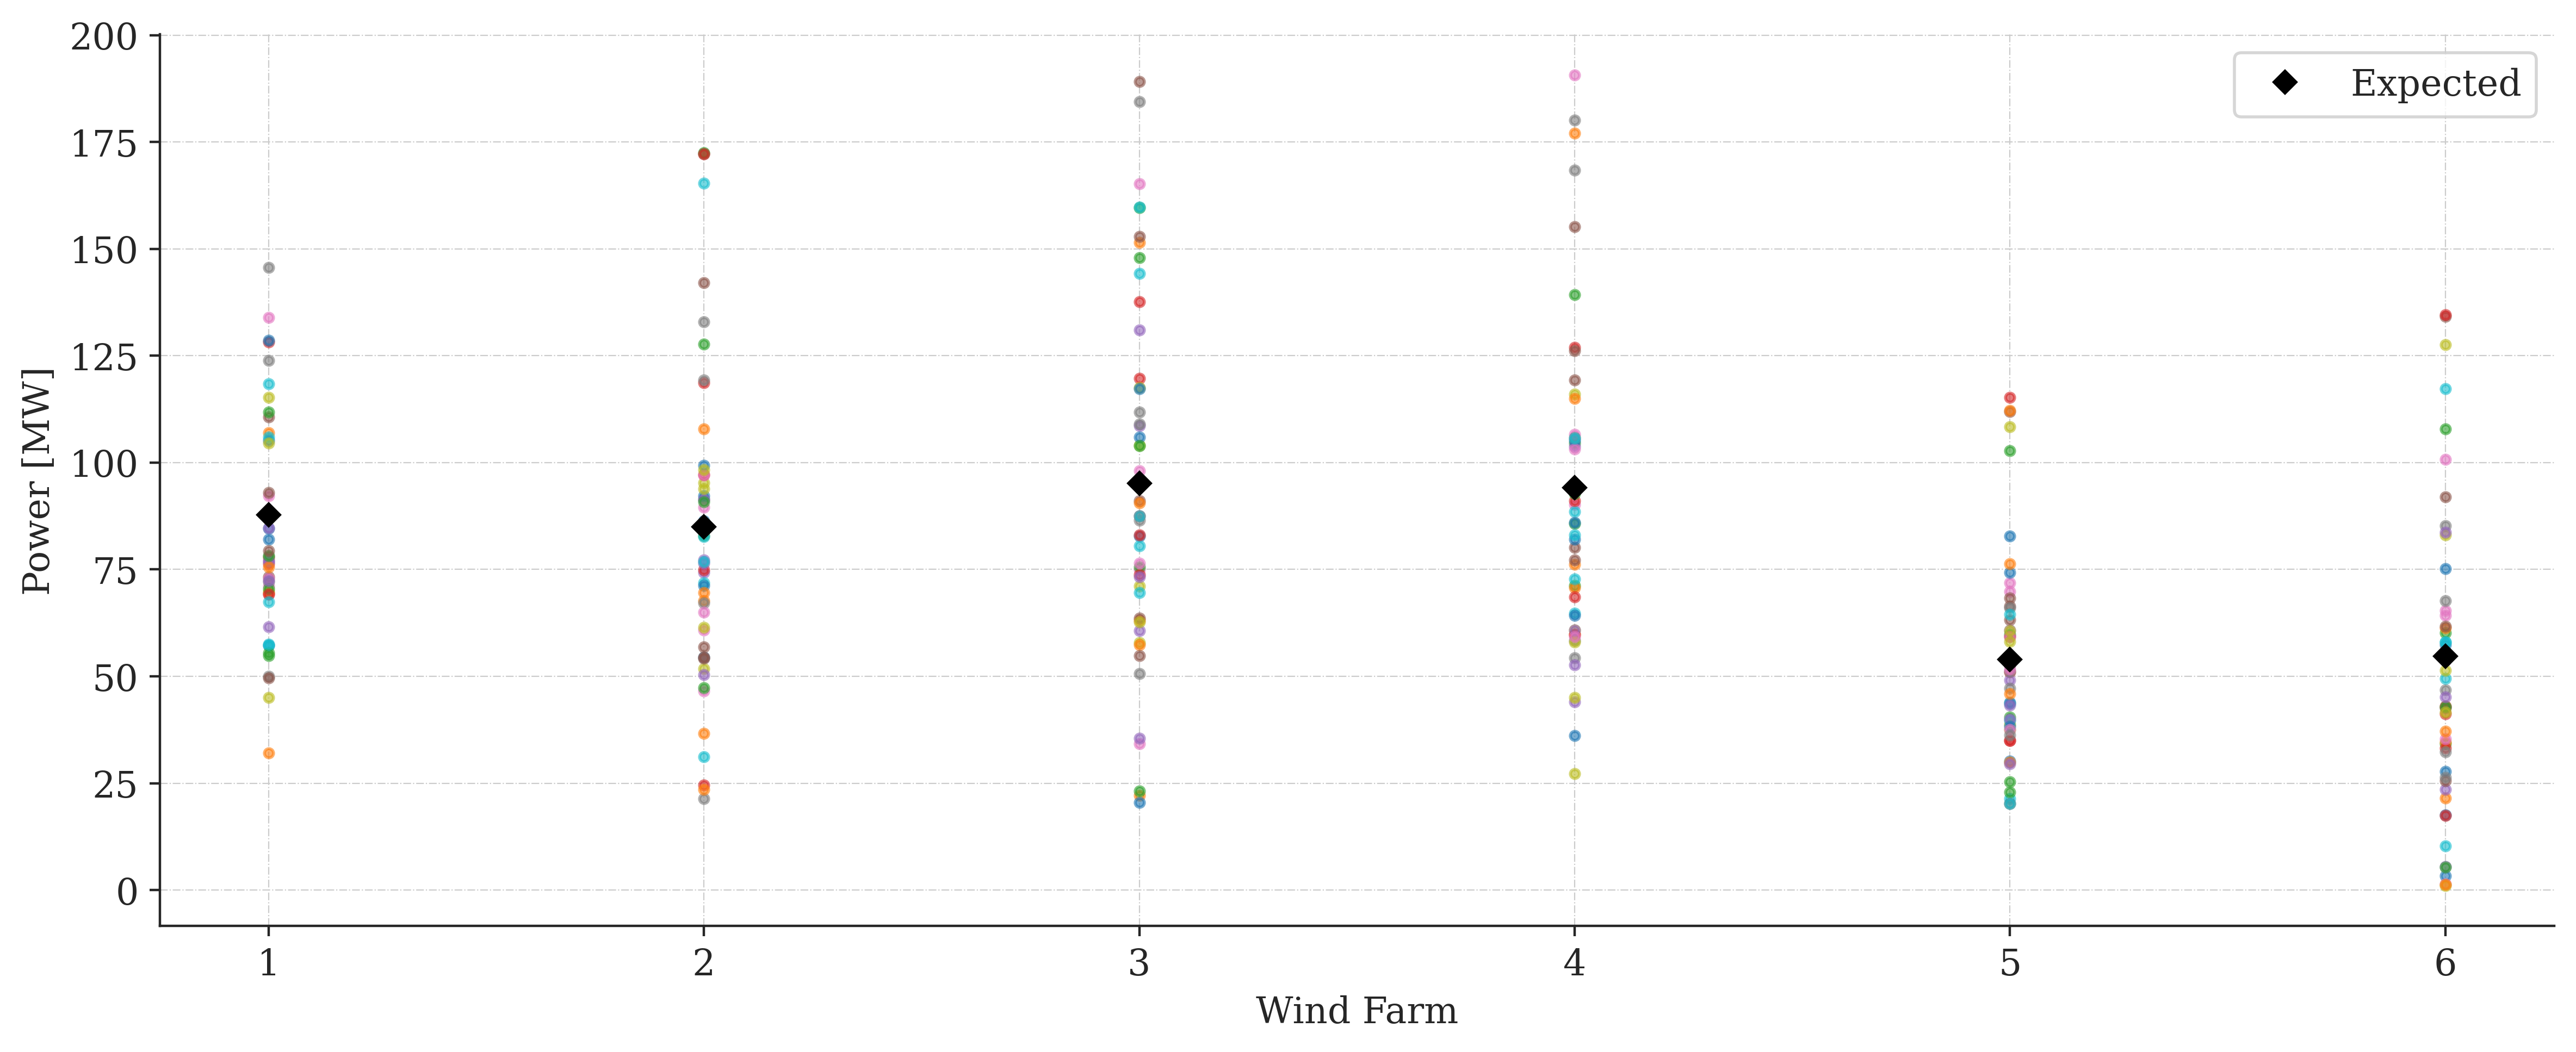

In [31]:
fig = plt.figure(figsize=( 12 , 5 ), dpi=400) # Create the figure
ax = fig.gca()
i = 1

for n in range(2):
    for k in range(3):
        ax.plot(wind_data.loc[wind_data.index == i][wind_data.columns[:-1].to_numpy()], alpha=0.6, linestyle='', marker='o', markersize=3)
        #ax.spines[['right', 'top']].set_visible(True)
        ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', markersize=5)
        #ax.set_title('Wind Farm %d' % (i))

        i += 1
        ax.set_xlabel('Wind Farm')

    ax.set_ylabel('Power [MW]')

ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', label = 'Expected', markersize=5)
plt.legend(loc = 'upper right')

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/wind_data_hour.png')
plt.show()

Assumption: Based on the exercises, we set the day-ahead cost of the wind farm to be 5% of the average cost of the gens and the regulation cost to be 10% of the average regulation cost of the gens

In [32]:
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs

,C ($/MWh),C+($/MWh),C-($/MWh)
0,0.62,1.41,0.90
1,0.62,1.41,0.90
2,0.62,1.41,0.90
3,0.62,1.41,0.90
4,0.62,1.41,0.90
5,0.62,1.41,0.90


"The commitment and ramping constraints and costs of all generators can be neglected."

In [33]:
gen_data = gen_data[['Unit #', 'Node', 'P max MW', 'R+ MW',	'R- MW']]
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


# Task 1b - Stochastic

### Setup model and solve

In [34]:
t = 0 #hour
demand = system_demand[t]

n_gen = len(gen_data.index)
n_wf = len(wind_data.index)
n_scenarios = len(wind_scenarios)
p_max_wf = 300

In [35]:
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


In [36]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model
m = gb.Model()
m.setParam("OutputFlag", 0)

# Add variables
p_G = m.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
p_W = m.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed
p_G_UP = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][g] * p_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * p_W[w] for w in range(n_wf)) + 1 / n_scenarios * (
                      gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios))
                      + gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))
                      )

m.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Day-ahead balance constraint
m.addConstr(gb.quicksum(p_G[g] for g in range(n_gen)) + gb.quicksum(p_W[w] for w in range(n_wf)) - demand == 0)

#Real-time balance constraint
m.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Output day-ahead limits
m.addConstrs(p_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))

#Real-time limits
m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #accounting for wind scenario

#Real-time regulating power bounds
m.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m.update()
#m.display()

m.optimize()

### Analyze results

In [37]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = wind_data['Expected'].values

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results['gen'] = generator_outputs.copy(deep=True)
    results['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     


-----------------------------------------------
Optimal objective value: 7567.75 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 30.00 MW
P_G[6]: 30.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 119.15 MW
P_G[11]: 40.00 MW
P_W[0]: 79.41 MW
P_W[1]: 86.37 MW
P_W[2]: 95.56 MW
P_W[3]: 91.03 MW
P_W[4]: 52.93 MW
P_W[5]: 51.39 MW
Dual value 1:  10.52
Dual value 2:  0.32
Dual value 3:  0.32
Dual value 4:  0.16
Dual value 5:  0.16
Dual value 6:  0.28
Dual value 7:  0.02816666666666667
Dual value 8:  0.28
Dual value 9:  0.28
Dual value 10:  0.16
Dual value 11:  0.3
Dual value 12:  0.3
Dual value 13:  0.14
Dual value 14:  0.16
Dual value 15:  0.32
Dual value 16:  0.16
Dual value 17:  0.02816666666666667
Dual value 18:  0.14
Dual value 19:  0.32
Dual value 20:  0.3
Dual value 21:  0.14
Dual value 22:  0.16
Dual value 23:  0.3
Dual value 24:  0.3
Dual value 25:  0.28
Dual value 26:  0.3
Dual value 27:  0.3
Dual value 28:  0.3
Dual val

3 x 6 with loading plots at the bottom and wind included next to generators


In [38]:
results.get('gen')

,p_G,Node,Loading Percentage
0,0.00,1,0.00
1,0.00,2,0.00
2,0.00,7,0.00
3,0.00,13,0.00
4,0.00,15,0.00
5,30.00,15,19.35
6,30.00,16,19.35
7,400.00,18,100.00
8,400.00,21,100.00
9,300.00,22,100.00


In [39]:
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


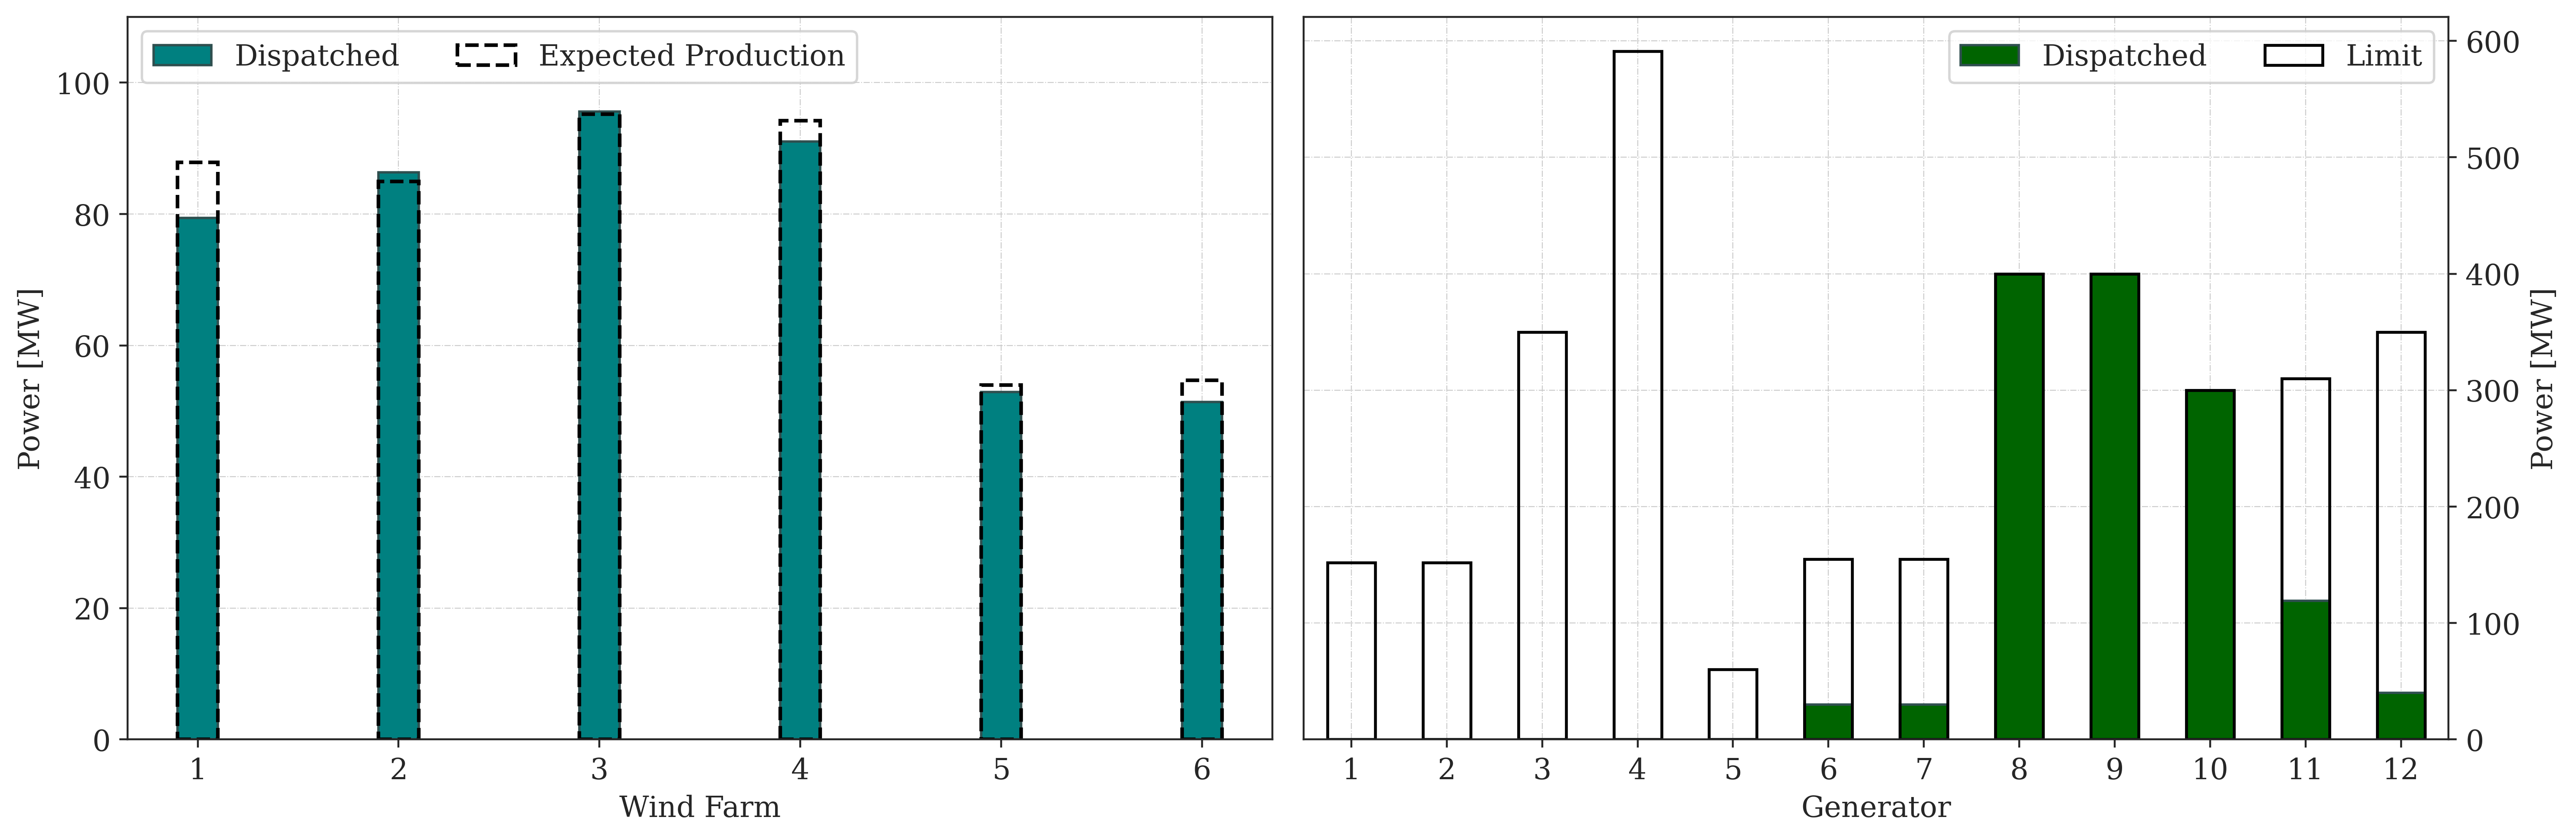

In [40]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,110])

(results.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
#((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

## Profit and cost-recovery analysis

In [41]:
#Uniform day-ahead price in $ is the dual value of the balance constraint
uniform_price_DA = dual_values[0]
DA_profits = {}

# Day-ahead dispatch
print('Day-ahead profits with uniform price %.2f $\n' % uniform_price_DA)
for g in range(n_gen):
    revenue = results.get('gen')['p_G'][g] * uniform_price_DA
    cost = results.get('gen')['p_G'][g] * gen_costs['C ($/MWh)'][g]
    profit = revenue - cost
    print('------------')
    print(f'Generator {g + 1}:')
    print('Dispatch: %.2f MW' % results.get('gen')['p_G'][g])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['G%d' % (g + 1)] = profit

for w in range(n_wf):
    revenue = results.get('wind')['p_W'][w] * uniform_price_DA
    cost = results.get('wind')['p_W'][w] * wf_costs['C ($/MWh)'][w]
    profit = revenue - cost
    print('------------')
    print(f'Wind Farm {w + 1}:')
    print('Dispatch: %.2f MW' % results.get('wind')['p_W'][w])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    DA_profits['WF%d' % (w + 1)] = profit

Day-ahead profits with uniform price 10.52 $

------------
Generator 1:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 2:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 3:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 4:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 5:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 6:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 7:
Dispatch: 30.00 MW
Revenue: 315.60 $
Cost: 315.60 $
Profit: 0.00 $
------------
Generator 8:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2408.00 $
Profit: 1800.00 $
------------
Generator 9:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2188.00 $
Profit: 2020.00 $
------------
Generator 10:
Dispatch: 300.00 MW
Revenue: 3156.00 $
Cost: 0.00 $
Profit: 3156.00 $
------------
Generator 11:
Dispat

In [42]:
# In each scenario, we can compute the profits with the up- and down-regulation power
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

real_time_profits = pd.DataFrame(data=np.zeros(n_scenarios), columns=['WF1'])
real_time_profits.index.name = 'Scenario'

for w in range(n_wf):
    real_time_profits['WF%d' % (w + 1)] = 0
for g in range(n_gen):
    real_time_profits['G%d' % (g + 1)] = 0

for n in range(n_scenarios):
    #the dual value of the constraint is the sensitivity of the objective function with respect to the constraint
    #since the objective function second stage term is weighted by the scenario probabilities (in this case uniform),
    #the actual price is reflected by the dual value times the number of scenarios (notice the 1/n_scenarios term in the objective function)
    adjustment_price = dual_values[n + 1] * n_scenarios 
    print('------------------------------------------')
    print('Scenario %d - real time adjustment cost of %.2f $' % (n + 1, adjustment_price))

    for g in range(n_gen):

        profit = p_G_UP[g,n].x * (adjustment_price - gen_costs['C+($/MWh)'][g]) + p_G_DOWN[g,n].x * (gen_costs['C-($/MWh)'][g] - adjustment_price)
        
        print('------------')
        print(f'Generator {g + 1}')
        print('Adjustment: %.2f MW' % ( p_G_UP[g,n].x - p_G_DOWN[g,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'G%d' % (g + 1)] = profit

    for w in range(n_wf):

        profit = p_W_UP[w,n].x * (adjustment_price - wf_costs['C+($/MWh)'][w]) + p_W_DOWN[w,n].x * (wf_costs['C-($/MWh)'][w] - adjustment_price)

        print('------------')
        print(f'Wind Farm {w + 1}')
        print('Day-ahead dispatch: %.2f MW' % results.get('wind')['p_W'][w])
        print('Realized power: %.2f MW' % (wind_data[wind_data.columns[n]].iloc[w]))
        print('Adjustment: %.2f MW' % ( p_W_UP[w,n].x - p_W_DOWN[w,n].x))
        print('Real-time Profit: %.2f $' % profit)

        real_time_profits.loc[real_time_profits.index == n,'WF%d' % (w + 1)] = profit
    

------------------------------------------
Scenario 1 - real time adjustment cost of 16.00 $
------------
Generator 1
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 2
Adjustment: 40.00 MW
Real-time Profit: 40.00 $
------------
Generator 3
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 4
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 5
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 6
Adjustment: 30.00 MW
Real-time Profit: 0.00 $
------------
Generator 7
Adjustment: 22.73 MW
Real-time Profit: 0.00 $
------------
Generator 8
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 9
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 10
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Generator 11
Adjustment: 60.00 MW
Real-time Profit: 120.00 $
------------
Generator 12
Adjustment: 0.00 MW
Real-time Profit: 0.00 $
------------
Wind Farm 1
Day-ahead dispatch: 79.41 MW
R

In [43]:
total_profits = real_time_profits.copy(deep=True)

for col in list(real_time_profits.columns):
    total_profits[col] = total_profits[col].values + DA_profits[col]

total_profits

,WF1,WF2,WF3,WF4,WF5,WF6,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12
Scenario,,,,,,,,,,,,,,,,,,
0,452.21,373.23,753.04,71.89,179.22,-217.74,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
1,760.73,104.72,-163.20,428.90,524.08,57.24,40.00,40.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,120.00,-14.80
2,611.36,830.76,1368.53,990.74,435.10,387.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
3,844.66,1068.61,1105.28,1137.96,510.18,436.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
4,552.04,697.31,1393.51,928.78,623.58,144.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
5,786.32,855.22,946.23,901.34,524.08,504.44,0.00,0.00,0.00,0.00,0.00,167.75,167.75,1800.00,2020.00,3156.00,395.50,248.87
6,676.78,333.26,675.47,891.12,762.26,684.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
7,767.08,919.06,357.63,420.50,518.87,935.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80
8,1022.67,914.06,772.44,686.45,414.80,717.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1800.00,2020.00,3156.00,0.00,-14.80


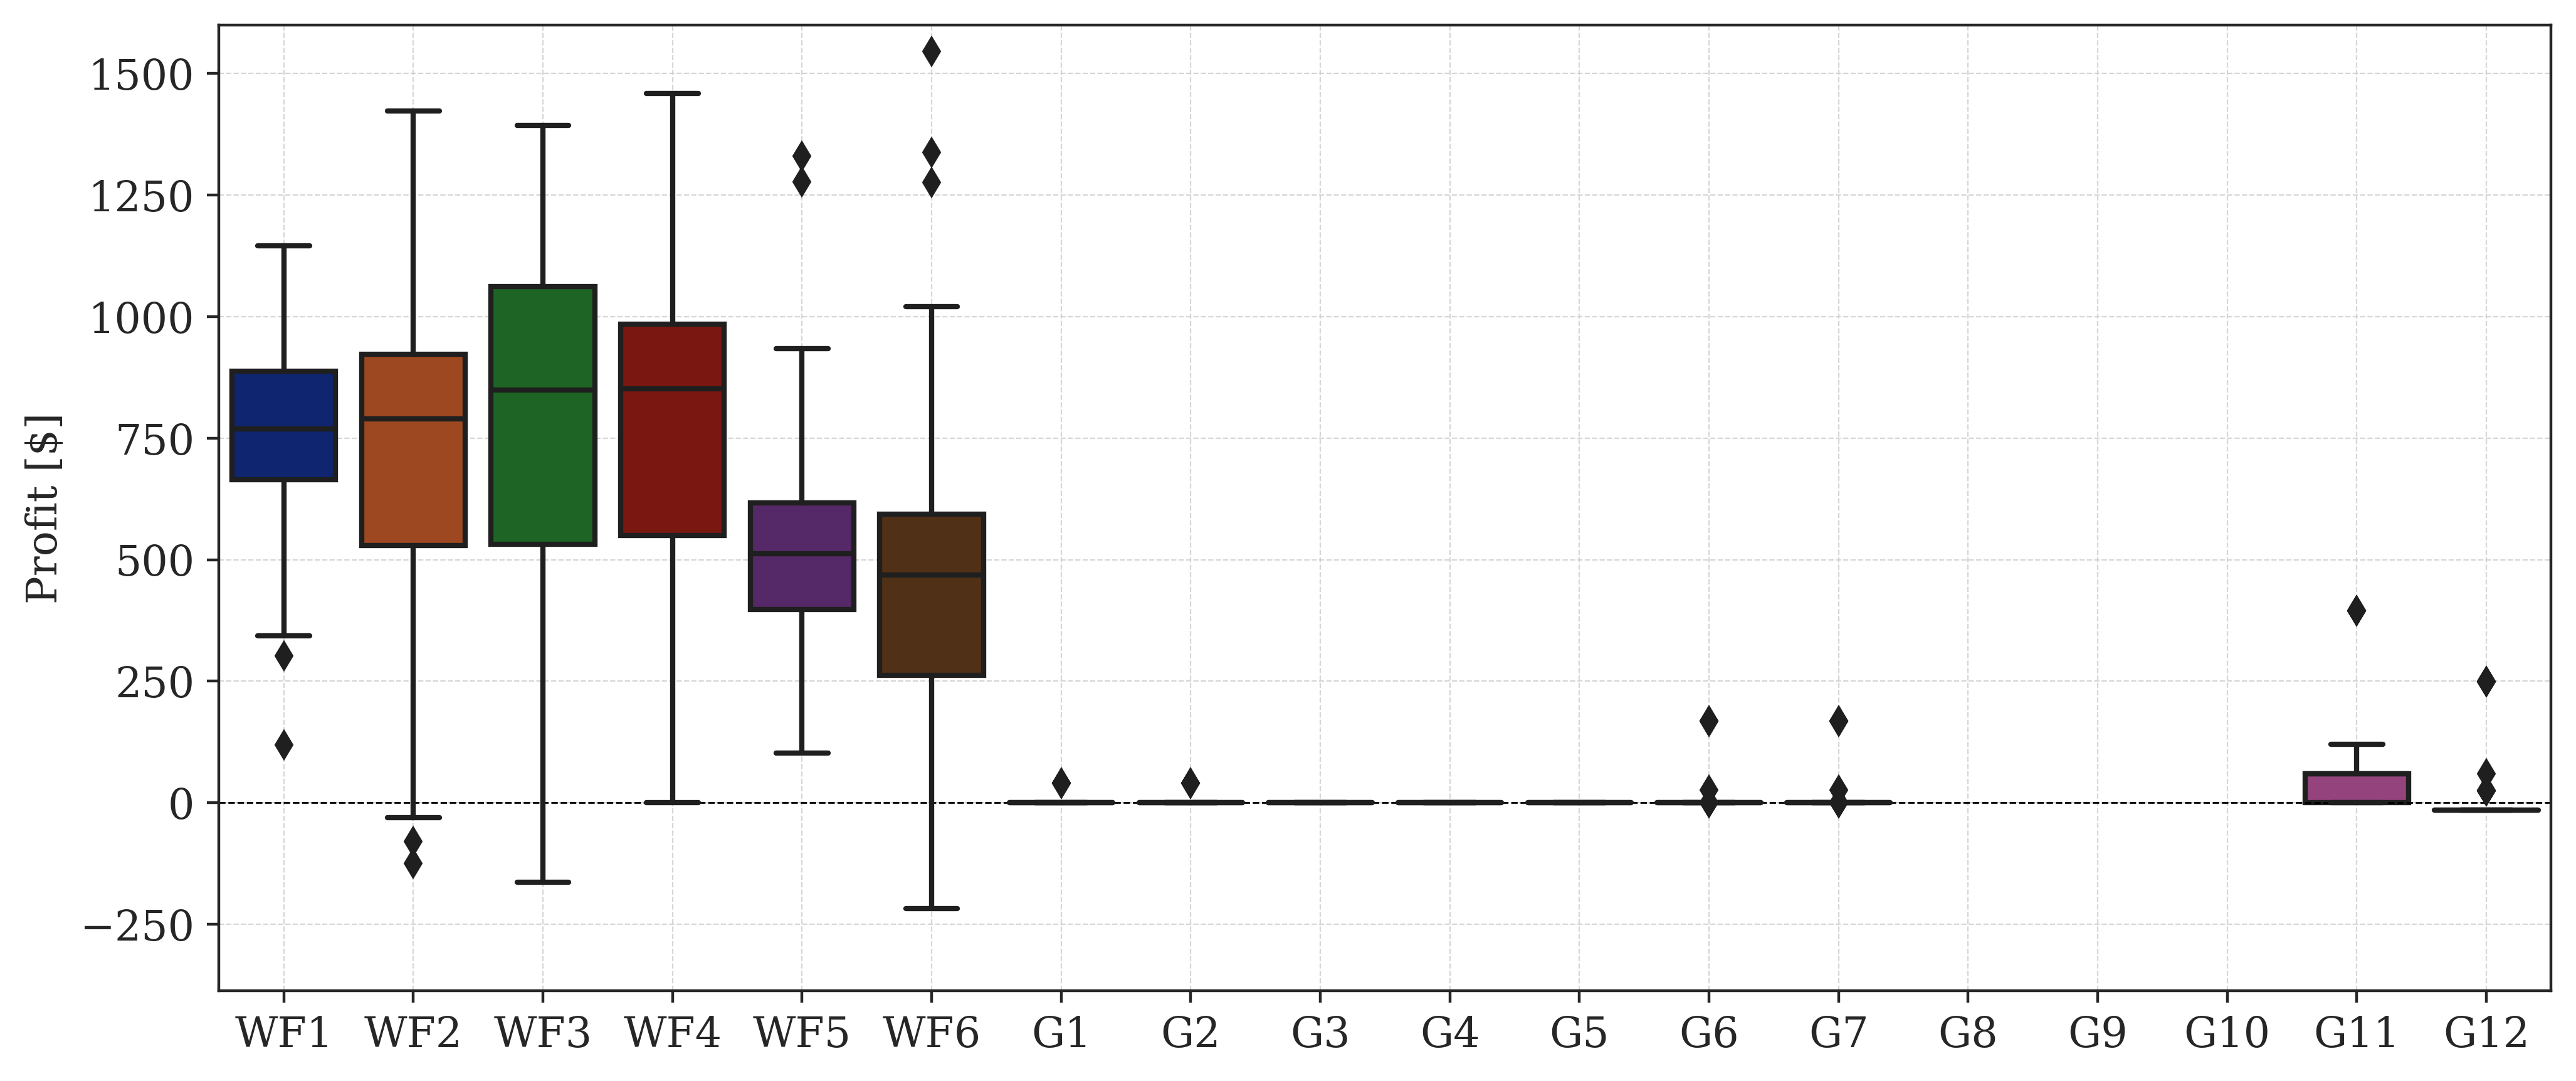

In [44]:
sns.set_style("ticks")
sns.set_style({'font.family':'serif'})
plt.figure(figsize=(12,5), dpi=400)

sns.boxplot(total_profits, zorder=5, palette='dark')

plt.ylim(ymax=1600)
plt.grid(linestyle='--', alpha=0.8, zorder=0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Profit [$]')


ax = fig.gca()
ax.set_axisbelow(True)

plt.savefig('Figures/profit_distribution.png', bbox_inches='tight')
plt.show()

# Task 1c - Deterministic

# Task 1d - Real-time Adjustments

# Task 2

In [48]:
class expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

class benders_subproblem: # Class representing the subproblems for each scenario

    def __init__(self,master,scenario,P_G_init,P_W_init): # initialize class
        self.data = expando() # define data attributes
        self.variables = expando() # define variable attributes
        self.constraints = expando() # define constraints attributes
        self.master = master # define master problem to which subproblem is attached
        self._init_data(scenario,P_G_init,P_W_init) # initialize data
        self._build_model() # build gurobi model
    
        
    def _init_data(self,scenario,P_G_init,P_W_init): # initialize data
        self.data.scenario = scenario # add scenario
        self.data.P_G_init = P_G_init # add initial value of complicating variables
        self.data.P_W_init = P_W_init # add initial value of complicating variables

    def _build_model(self): # build gurobi model
        
        self.model = gb.Model(name='subproblem') # build model
        self._build_variables() # add variables
        self._build_objective() # add objective
        self._build_constraints() # add constraints
        self.model.update() 


    def _build_variables(self): # build variables

        #index shortcut 
        m = self.model
        
        # complicating variables
        self.variables.P_G = m.addVars(n_gen,lb=0,ub=gb.GRB.INFINITY,name='P_G') 
        self.variables.P_W = m.addVars(n_wf, lb=0,ub=gb.GRB.INFINITY ,name='P_W')

        self.variables.P_G_UP = m.addVars(n_gen, n_scenarios, lb=0,ub=gb.GRB.INFINITY,name='P_G_UP') # electricity production adjustment of generators in real time (\Delta x^G_i)
        self.variables.P_G_DW = m.addVars(n_gen, n_scenarios,lb=0,ub=gb.GRB.INFINITY,name='P_G_DW') # electricity production adjustment of generators in real time (\Delta x^G_i)
        self.variables.P_W_UP = m.addVars(n_wf, n_scenarios, lb=0,ub=gb.GRB.INFINITY, name='P_W_UP') # electricity production adjustment of generators in real time (\Delta x^G_i)
        self.variables.P_W_DW = m.addVars(n_wf, n_scenarios, lb=0,ub=gb.GRB.INFINITY,name='P_W_DW')# electricity production adjustment of generators in real time (\Delta x^G_i)
       
       
        m.update() # update model
    

    def _build_objective(self): # define objective function
 
        #index shortcut 
        m = self.model

        # Set the objective function for the suproblem
        subproblem_obj = gb.quicksum((gen_costs['C+($/MWh)'][g] * self.variables.P_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * self.variables.P_G_DW[g,k]) for g in range(n_gen) for k in range(n_scenarios)) + gb.quicksum((wf_costs['C+($/MWh)'][w] * self.variables.P_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * self.variables.P_W_DW[w,k]) for w in range(n_wf) for k in range(n_scenarios))   
        m.setObjective(subproblem_obj, gb.GRB.MINIMIZE) #minimize cost

        m.update() 
        

    def _build_constraints(self):

        #index shortcut 
        m = self.model
              
        self.constraints.P_G_i = m.addConstrs(self.variables.P_G[g] >= self.data.P_G_init[g] for g in range(n_gen))# constraints that fix complicating variables to master problem solutions
                        
        self.constraints.P_W_i = m.addConstrs(self.variables.P_W[w] >= self.data.P_W_init[w] for w in range(n_wf))# constraints that fix complicating variables to master problem solutions
                        
        #Real-time balance constraint
        self.constraints.RT_balance_constraint = m.addConstrs(gb.quicksum(self.variables.P_G_UP[g,k] - self.variables.P_G_DW[g,k] for g in range(n_gen)) + 
                                                                  gb.quicksum(self.variables.P_W_UP[w,k] - self.variables.P_W_DW[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))
        
        self.constraints.adjustment_max_generation_constraint = {} #max production of generators after adjustment
        
        #Real-time limits
        self.constraints.RT_G_min = m.addConstrs(self.variables.P_G[g] + self.variables.P_G_UP[g,k] - self.variables.P_G_DW[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
        self.constraints.RT_W_min = m.addConstrs(self.variables.P_W[w] + self.variables.P_W_UP[w,k] - self.variables.P_W_DW[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

        self.constraints.RT_G_max = m.addConstrs(self.variables.P_G[g] + self.variables.P_G_UP[g,k] - self.variables.P_G_DW[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
        self.constraints.RT_W_max = m.addConstrs(self.variables.P_W[w] + self.variables.P_W_UP[w,k] - self.variables.P_W_DW[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #accounting for wind scenario

        #Real-time regulating power bounds
        self.constraints.P_UP_PB = m.addConstrs(self.variables.P_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
        self.constraints.P_DW_PB = m.addConstrs(self.variables.P_G_DW[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

        self.constraints.W_UP_PB = m.addConstrs(self.variables.P_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
        self.constraints.W_DW_PB = m.addConstrs(self.variables.P_W_DW[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
                
        m.update()


    def _update_complicating_variables(self): # function that updates the value of the complicating variables

        # index shortcut
        m = self.model

        for g in range(n_gen):
            self.constraints.P_G_i[g].rhs = self.master.variables.P_G[g].x
        for w in range(n_wf):
            self.constraints.P_W_i[w].rhs = self.master.variables.P_W[w].x
    
        m.update()



class benders_master: # class of master problem
    
    def __init__(self,epsilon,max_iters): # initialize class
        self.data = expando() # build data attributes
        self.variables = expando() # build variable attributes
        self.constraints = expando() # build contraint attributes
        self._init_data(epsilon,max_iters) # initialize data
        self._build_model() # build gurobi model
    
        
    def _init_data(self,epsilon,max_iters): # initialize data

        self.data.epsilon = epsilon # add value of convergence criteria
        self.data.max_iters = max_iters # add max number of iterations
        self.data.iteration = 1 # initialize value of iteration count
        self.data.upper_bounds = {} # initialize list of upper-bound values
        self.data.lower_bounds = {} # initialize list of lower-bound values
        self.data.P_G_duals = {} # initialize list of sensitivities values
        self.data.P_G_values = {} # initialize list of complicating variables values
        self.data.P_W_duals = {} # initialize list of sensitivities values
        self.data.P_W_values = {} # initialize list of complicating variables values
        self.data.gamma_values = {} # initialize list of gamma values
        self.data.subproblem_objectives = {} # initialize list of subproblems objective values
        self.data.master_objectives = {} # initialize list of master problem objective values

    def _build_model(self): # build gurobi model
        
        self.model = gb.Model(name='master') # build model
        self._build_variables() # add variables
        self._build_objective() # add objective
        self._build_constraints() # add constraints
        self.model.update()


    def _build_variables(self): # build variables

        #index shortcut 
        m = self.model
        
        # complicating variables
        self.variables.P_G = m.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
        self.variables.P_W = m.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed

        # gamma = approximator of subproblems' objective value
        self.variables.gamma = m.addVar(lb=-1000,name='gamma')
        m.update()
    

    def _build_objective(self): # build objective
 
        #index shortcut 
        m = self.model 

        # Set the objective function for the master problem
        master_obj = gb.quicksum(gen_costs['C+($/MWh)'][g]*self.variables.P_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * self.variables.P_W[w] for w in range(n_wf)) + self.variables.gamma # expected electricity production cost (z)     
        m.setObjective(master_obj, gb.GRB.MINIMIZE) #minimize cost

        m.update() 

    def _build_constraints(self): # build constraints

        #index shortcut 
        m = self.model
            
       #Day-ahead constraint
        self.constraints.DA = m.addConstr(gb.quicksum(self.variables.P_G[g] for g in range(n_gen)) + gb.quicksum(self.variables.P_W[w] for w in range(n_wf)) - demand == 0)
        
        self.constraints.DA_G = m.addConstrs(self.variables.P_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))
       
        self.constraints.master_cuts = {} # initialize master problem cuts (empty)
        
        m.update()


    def _build_subproblems(self): # function that builds subproblems
        
        self.subproblem = {k:benders_subproblem(self,scenario=k,P_G_init={g:self.variables.P_G[g].x for g in range(n_gen)},
                                                P_W_init={w:self.variables.P_W[w].x for w in range(n_wf)}) 
                          for k in range(n_scenarios)}
        
        

       

    def _update_master_cut(self): # fucntion tat adds cuts to master problem

        # index shortcut
        m = self.model

        self.constraints.master_cuts[self.data.iteration] = m.addConstr(
            self.variables.gamma,
            gb.GRB.GREATER_EQUAL,
            gb.quicksum((1/n_scenarios)*(self.data.subproblem_objectives[self.data.iteration-1][k] + 
                                        (gb.quicksum(self.data.P_G_duals[self.data.iteration-1][g,k]*(self.variables.P_G[g]-
                                        self.data.P_G_values[self.data.iteration-1][g]) for g in range(n_gen))+
                                        gb.quicksum(self.data.P_W_duals[self.data.iteration-1][w,k]*(self.variables.P_W[w]-
                                        self.data.P_W_values[self.data.iteration-1][w]) for w in range(n_wf)))) for k in range(n_scenarios)), 
                                        name='new (uni)-cut at iteration {0}'.format(self.data.iteration))

        

        m.update()
    
    
    def _save_master_data(self): # function that saves results of master problem optimization at each iteration (complicating variables, objective value, lower bound value)
        
        # index shortcut
        m = self.model
        
        # save complicating variables value
        self.data.P_G_values[self.data.iteration] = {g:self.variables.P_G[g].x for g in range(n_gen)}
        self.data.P_W_values[self.data.iteration] = {w:self.variables.P_W[w].x for w in range(n_wf)}
        
        # save gamma value
        self.data.gamma_values[self.data.iteration] = self.variables.gamma.x
          
        # save lower bound value
        self.data.lower_bounds[self.data.iteration] = m.ObjVal

        # save master problem objective value
        self.data.master_objectives[self.data.iteration] = m.ObjVal - self.variables.gamma.x
           
        m.update()

    def _save_subproblems_data(self): # function that saves results of subproblems optimization at each iteration (sensitivities, objective value, upper bound value)
        
        # index shortcut
        m = self.model

        # save sensitivities (for each complicating variables in each subproblem)
        self.data.P_G_duals[self.data.iteration] = {(g,k):self.subproblem[k].constraints.P_G_i[g].Pi for g in range(n_gen) for k in range(n_scenarios)}
        self.data.P_W_duals[self.data.iteration] = {(w,k):self.subproblem[k].constraints.P_W_i[w].Pi for w in range(n_wf) for k in range(n_scenarios)}

        # save subproblems objective values
        self.data.subproblem_objectives[self.data.iteration] = {k:self.subproblem[k].model.ObjVal for k in range(n_scenarios)}             
        
        # save upper bound value
        self.data.upper_bounds[self.data.iteration] = self.data.master_objectives[self.data.iteration] + sum((1/n_scenarios)*self.subproblem[k].model.ObjVal for k in range(n_scenarios))
                      
        m.update()

    def _do_benders_step(self): # function that does one benders step
        
        # index shortcut
        m = self.model

        self.data.iteration += 1 # go to next iteration        
        self._update_master_cut() # add cut
        m.optimize() # optimize master problem
        self._save_master_data() # save master problem optimization results
        for k in range(n_scenarios): 
            self.subproblem[k]._update_complicating_variables() # update value of complicating constraints in subproblems
            self.subproblem[k].model.optimize() # solve subproblems
        self._save_subproblems_data() # save subproblems optimization results

               
    def _benders_iterate(self): # function that solves iteratively the benders algorithm

        # index shortcut            
        m = self.model
        m.setParam('OutputFlag', 0)
        
        # initial iteration: 
        m.optimize() #   solve master problem (1st iteration)
        self._save_master_data() # save results of master problem and lower bound
        self._build_subproblems() # build subproblems (1st iteration)
        for k in range(n_scenarios): 
            self.subproblem[k].model.optimize() # solve subproblems
        self._save_subproblems_data() # save results of subproblems and upper bound

        # do benders steps until convergence
        while (
            (abs(self.data.upper_bounds[self.data.iteration] - self.data.lower_bounds[self.data.iteration])>self.data.epsilon and
                self.data.iteration < self.data.max_iters)):
            self._do_benders_step()

#solve and print results

DA_model = benders_master(epsilon=0.1,max_iters=50)
DA_model._benders_iterate()

print('uni-cut optimal cost',DA_model.data.upper_bounds[DA_model.data.iteration]) # print optimal cost (last upper-bound)


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3668 rows, 1818 columns and 9018 nonzeros
Model fingerprint: 0x549a4571
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 2168 rows and 304 columns
Presolve time: 0.02s

Solved in 0 iterations and 0.03 seconds (0.00 work units)
Infeasible or unbounded model
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3668 rows, 1818 columns and 9018 nonzeros
Model fingerprint: 0x549a4571
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
 

AttributeError: Unable to retrieve attribute 'Pi'